# Cross validation and model selection

- Load some stock datasets from sklearn.datasets, and create our own nonlinear regression problem
 - show how to use pipelines to create an L2-regularised polynomial nonlinear regression
 - Use basic k-fold cross-validatin to measure the training/test error as we vary the polynomial degree and the regularisation

Things not covered:

 - Choice of validation metric, and multi-metric evaluation
 - Many available CV iterators (ways of splitting the data): in particular, with time-series awareness (so we don't train on future data), and with class awareness (so samples from same class, e.g. pertaining to same asset in a multi-asset finance stragegy) don't appear in same set.
 - PArameter optimisation. Exhaustive grid search is basic approach, but there are many model-specific approaches

In [1]:
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles, make_biclusters
import sklearn.datasets.samples_generator as sg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn.linear_model as slm
import sklearn.model_selection as sms
import sklearn.preprocessing as skp
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import warnings


### Classification problems
Various functions for making classification problems with Gaussan and non-Gaussian data

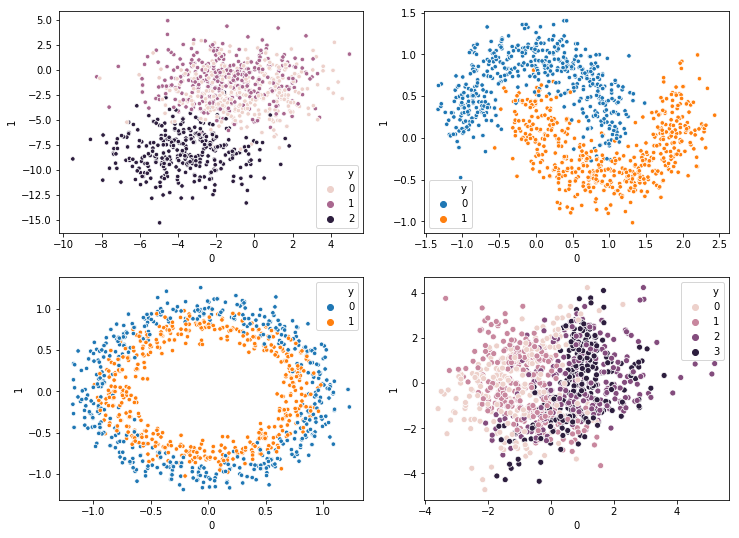

In [2]:
fig, ax = plt.subplots(2,2,figsize=(12,9))
xydf = lambda X, y : pd.concat((pd.DataFrame(X), pd.Series(y).to_frame("y")), axis=1)
sns.scatterplot(data=xydf(*make_blobs(n_samples=1000, centers=3, n_features=5, cluster_std=2)), x=0, y=1, hue='y', s=20, ax=ax[0,0])
sns.scatterplot(data=xydf(*make_moons(n_samples=1000, noise=0.2)), x=0, y=1, hue='y', s=20, ax=ax[0,1])
sns.scatterplot(data=xydf(*make_circles(n_samples=1000, noise=0.1)), x=0, y=1, hue='y', s=20, ax=ax[1,0])
# make_classification extends make_blobs (in all kinds of challenging ways)
sns.scatterplot(data=xydf(*sg.make_classification(n_samples=1000, n_features=5, n_informative=3, n_classes=4)), x=0, y=1, hue='y', ax=ax[1,1])
None

### Regression problems
Linear and nonlinear

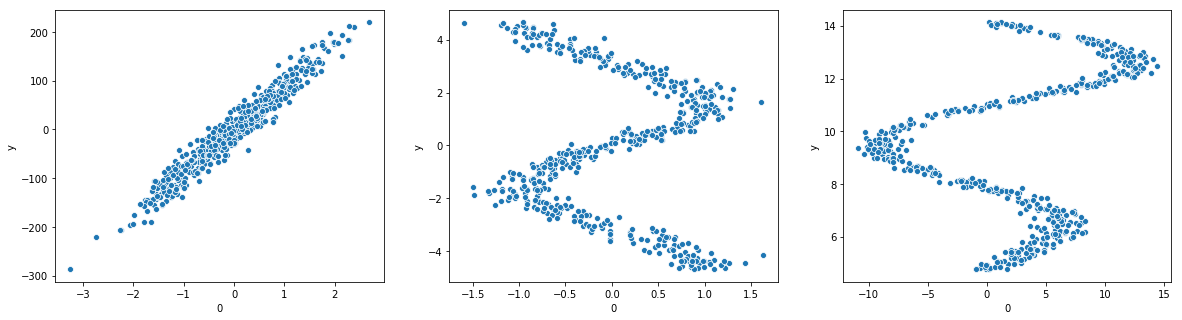

In [3]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(data = xydf(*sg.make_regression(n_samples=500, n_features=1, noise=20)), x=0, y='y', ax=ax[0])
sns.scatterplot(data = xydf(*sg.make_s_curve(n_samples=500, noise=0.2)), x=0, y='y', ax=ax[1])
sns.scatterplot(data = xydf(*sg.make_swiss_roll(n_samples=500, noise=1)), x=0, y='y', ax=ax[2])

### Specific example regression problems
The Friedman regression problems

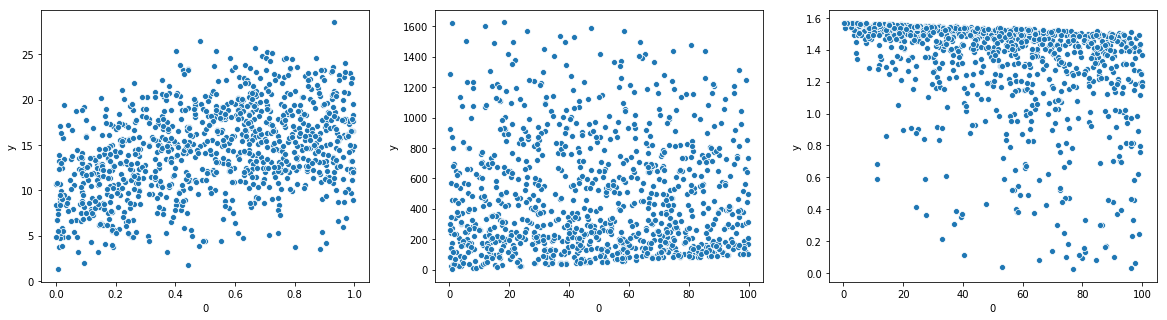

In [4]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(data = xydf(*sg.make_friedman1(n_samples=1000)), x=0, y='y', ax=ax[0])
sns.scatterplot(data = xydf(*sg.make_friedman2(n_samples=1000)), x=0, y='y', ax=ax[1])
sns.scatterplot(data = xydf(*sg.make_friedman3(n_samples=1000)), x=0, y='y', ax=ax[2])

Solving a linear regression problem:

In [5]:
# generate the data. bit frustrating that there isn't a make_nonlinear_regression function...
np.random.seed(1)
import numpy as np
x = np.random.normal(size=1000)
coeff = np.random.normal(size=3)
offset = np.random.normal()
y=x
e=x
for i in range(3):
    a, b, c, d = np.random.normal(size=4)
    y = c*np.sin(a*y+b)+d
    a, b, c, d = np.random.normal(size=4)
    e = c*np.sin(a*e+b)+d

y = y+0.01*np.random.normal(size=len(x))*np.abs(e)
X = x.reshape(-1,1) # features are expected as a 2d array

,linear,poly
train,0.20,0.83
test,0.12,0.85


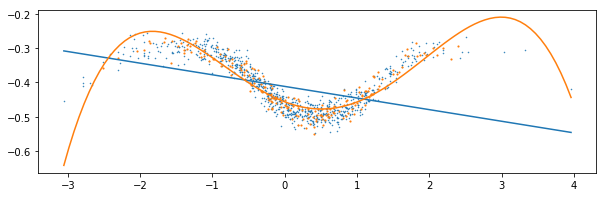

In [6]:

fig, ax = plt.subplots(1,1,figsize=(10,3), squeeze=False)

Xtrain, Xtest, ytrain, ytest = sms.train_test_split(X, y, test_size=0.2)
linear_model = slm.LinearRegression()
linear_model.fit(Xtrain,ytrain)
ax[0,0].scatter(Xtrain,ytrain, marker='.', s=1)
ax[0,0].scatter(Xtest,ytest, marker='.', s=5)
ax[0,0].plot(sorted(X),linear_model.predict(sorted(X)))
linear_model.score(Xtrain,ytrain), linear_model.score(Xtest, ytest) #  for a linear regression, the score is the R2

from sklearn.pipeline import Pipeline
steps = [("polynomial",skp.PolynomialFeatures(4)),("linear_reg",slm.LinearRegression())]
poly_model = Pipeline(steps)
poly_model.fit(Xtrain,ytrain)
np.linspace(min(X), max(X), 101)

ax[0,0].plot(np.linspace(min(X), max(X), 101),poly_model.predict(np.linspace(min(X), max(X), 101).reshape(-1,1)))
None

pd.DataFrame(
    {"linear" : [linear_model.score(Xtrain,ytrain), linear_model.score(Xtest,ytest)],
    "poly" : [poly_model.score(Xtrain,ytrain), poly_model.score(Xtest,ytest)]}, index=("train","test")).round(2)



In [7]:
cv=5
pd.DataFrame({"poly" : cross_val_score(poly_model, X, y, cv=5),
"linear" : cross_val_score(linear_model, X, y, cv=cv)}).round(2).T

# note that by default cross_val_score returns estimator.score(), this can be chnaged
# it is also possible to change the cross-validation strategy, different train/test splits etc.

,0,1,2,3,4
poly,0.86,0.83,0.77,0.84,0.80
linear,0.17,0.09,0.11,0.28,0.14


In [11]:
pd.DataFrame(cross_validate(linear_model, X, y, cv=5)).round(4)

/home/sejones/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,test_score,train_score
0,0.0014,0.0011,0.1674,0.1861
1,0.0016,0.0012,0.0949,0.1993
2,0.0011,0.0011,0.1137,0.1993
3,0.0017,0.0009,0.2788,0.1540
4,0.0011,0.0013,0.1411,0.1869


In [9]:
models = [Pipeline([("polynomial",skp.PolynomialFeatures(i)),("linear_reg",slm.LinearRegression())]) for i in range(10)]

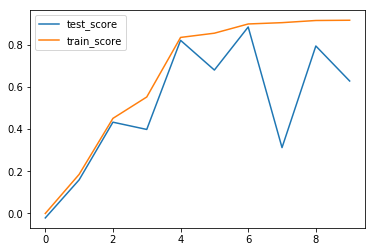

In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    pd.concat([pd.DataFrame(cross_validate(m, X, y, cv=5)).mean() for m in models], axis=1).T[["test_score","train_score"]].plot()

In [226]:
slm.Ridge()
slm.Lasso()
slm.ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
slm.Ridge(alpha=0.01)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

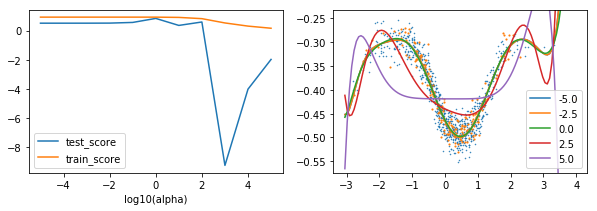

In [69]:
alpha = 10.**np.linspace(-5,5,11)

fig, ax = plt.subplots(1,2,figsize=(10,3), squeeze=False)

models =[Pipeline([("polynomial",skp.PolynomialFeatures(10)),("linear_reg",slm.Ridge(alpha=x))]) for x in alpha]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    result = pd.concat([pd.DataFrame(cross_validate(m, X, y, cv=5)).mean() for m in models], axis=1).T[["test_score","train_score"]]
result.index = np.log10(alpha)
result.index.name = "log10(alpha)"
result
result.plot(ax=ax[0,0])

Xtrain, Xtest, ytrain, ytest = sms.train_test_split(X, y, test_size=0.2)
linear_model = slm.Ridge(alpha=0.01)
linear_model.fit(Xtrain,ytrain)
ax[0,1].scatter(Xtrain,ytrain, marker='.', s=1)
ax[0,1].scatter(Xtest,ytest, marker='.', s=5)

np.linspace(min(X), max(X), 101)

for x in np.linspace(-5.,5.,5):
    ridge_model = Pipeline([("polynomial",skp.PolynomialFeatures(10)),("linear_reg",slm.Ridge(alpha=10**x))])
    ridge_model.fit(Xtrain,ytrain)
    ax[0,1].plot(np.linspace(min(X), max(X), 101),ridge_model.predict(np.linspace(min(X), max(X), 101).reshape(-1,1)), label=x)

ax[0,1].set_ylim(min(y)-0.3*np.std(y),max(y)+0.3*np.std(y))
plt.legend()

None